# Programming Project #2: Image Quilting

## CS445: Computational Photography - Fall 2019

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

import utils
import os
import random


In [2]:
from utils import cut # default cut function for seam finding section

#### Common methods and global variables

In [3]:
def fill_patch(img_r, img_g, img_b, src_i, src_j, patch_h, patch_w, debug=False):
    
    patch = np.zeros((patch_h, patch_w,3))
     
    for i in range(patch_h):
        for j in range(patch_w):
            if(debug):
                print('i: ', str(i), ' j: ', str(j), \
                      ' src_i:', str(src_i+i), ' src_j: ', str(src_j+j))
            patch[i][j][0] = img_r[src_i + i][src_j + j]
            patch[i][j][1] = img_g[src_i + i][src_j + j]
            patch[i][j][2] = img_b[src_i + i][src_j + j]
        
    return patch


In [4]:
def select_random_patch(img_r, img_g, img_b, img_h, img_w, patch_h, patch_w, debug=False):
    
    src_i = random.randrange(0, img_h - patch_h)
    src_j = random.randrange(0, img_w - patch_w)
   
    if(debug):
        print('select_random_patch:: '\
          ' src_i: ' , str(src_i), ' src_j: ', str(src_j), \
          ' height: ', str(patch_h), ' width: ', str(patch_w))
    
    patch = fill_patch(img_r, img_g, img_b,src_i, src_j, patch_h, patch_w, False)
    
    return patch


In [5]:
def generate_samples(img, patch_size):
    
    h,w,c = img.shape
    
    # Generate 10% of total possible sample
    num_samples = int(min(h-patch_size,w-patch_size) * 0.1)
    
    # Generate at least 10 samples
    if (num_samples < 10):
        num_samples = 10
   
    img_b, img_g, img_r = cv2.split(img)
    img_height, img_width, channels = img.shape
    
    samples = []
    
    for i in range(num_samples):
        patch = select_random_patch(img_r, img_g, img_b, img_height, img_width, patch_size, patch_size)
        samples.append(patch)
        
    print('Number of samples generated:', str(len(samples)))
    
    return samples


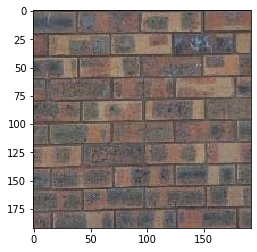

In [6]:
sample_img_path = 'samples/bricks_small.jpg' # feel free to change
sample_img = None
sample_img_rgb = None

if os.path.exists(sample_img_path):
    sample_img = cv2.imread(sample_img_path)
    sample_img_rgb = cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB)
    plt.imshow(sample_img_rgb)
    

### Part I: Randomly Sampled Texture (10 pts)

In [7]:
def pick_random_patch(h_range, w_range):
    i = random.randrange(0, h_range)
    j = random.randrange(0, w_range)
    
    return (i,j)

In [8]:
def quilt_random(in_img, out_size, patch_size):
    """
    Randomly samples square patches of size patchsize from sample in order to create an output image of size outsize.

    :param sample: numpy.ndarray    The image you read from sample directory
    :param out_size: int            The width of the square output image
    :param patch_size: int          The width of the square sample patch
    :return: numpy.ndarray
    """
    
    h,w,c = in_img.shape
    
    print('Height: ', str(h), 'Width: ', str(w), ' channels: ', str(c))
    
    in_img_b, in_img_g, in_img_r = cv2.split(in_img)
        
    print('in_img_b: ',in_img_b.shape, ' in_img_g: ', in_img_g.shape, ' in_img_r: ', in_img_r.shape)
    
    out_img_r = np.zeros((out_size, out_size))
    out_img_g = np.zeros((out_size, out_size))
    out_img_b = np.zeros((out_size, out_size))
                      
    dst_i = 0 
    dst_j = 0
    
    while dst_i < out_size: 
        
        src_i, src_j = pick_random_patch( h-patch_size, w-patch_size)
    
        for i in range(patch_size):        
            while (dst_j < out_size):
                for j in range(patch_size):
                    out_img_r[dst_i][dst_j] = in_img_r[i][j] 
                    out_img_g[dst_i][dst_j] = in_img_g[i][j]
                    out_img_b[dst_i][dst_j] = in_img_b[i][j]
            
                    dst_j += 1
                    if (dst_j == out_size):
                        break
                        
                
                src_i, src_j = pick_random_patch( h-patch_size, w-patch_size)
                #print('src_i: ', str(src_i), ' src_j:', str(src_j))
                
                if (dst_j == out_size):
                        dst_j = 0
                        break
                        
            dst_i += 1
            if (dst_i == out_size):
                break
        
    
    out_img_bgr = cv2.merge((out_img_b, out_img_g, out_img_r))
    out_img_rgb = cv2.merge((out_img_r, out_img_g, out_img_b))
    
    return (out_img_bgr, out_img_rgb)


Height:  192 Width:  192  channels:  3
in_img_b:  (192, 192)  in_img_g:  (192, 192)  in_img_r:  (192, 192)


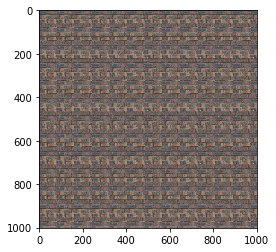

In [9]:
output_path = 'my_images/'

out_size = 1001  # feel free to change to debug
patch_size = 81 # feel free to change to debug

(out_img_rand, out_img_rand_rgb) = quilt_random(sample_img, out_size, patch_size)
out_img_rand_path = os.path.join(output_path, 'output_quilt_rand_'+ str(patch_size) + '.jpg')

if out_img_rand is not None:
    cv2.imwrite(out_img_rand_path, out_img_rand)
    plt.imshow(out_img_rand_rgb.astype('uint8'))
    

### Part II: Overlapping Patches (30 pts)

In [10]:
def ssd_patch(prev_patch, new_patch, patch_size, overlap, debug=False):
    
    height = patch_size
    width = 2*(patch_size - overlap)
    
    if(debug):
        print('ssd_patch:: template height: ', str(height) , ' width: ', width)
    
    mask = np.zeros((height, width, 3))
    template = np.zeros((height, width, 3))
    
    #print('Mask.shape: ', mask.shape)
    #print('Template.shape: ',template.shape)
    
    for i in range(height):
        k = 0
        for j in range(patch_size - overlap):
            template[i][j][0] = prev_patch[i][j][0]
            template[i][j][1] = prev_patch[i][j][1]
            template[i][j][2] = prev_patch[i][j][2]
            k += 1
        
        #print('After patch 1: current i: ', str(i),' current k: ', str(k))
        
        mask_window = k+overlap
        while k < mask_window:
            mask[i][k][0] = 1
            mask[i][k][1] = 1
            mask[i][k][2] = 1
            k+=1 
            
    '''            
     Reference: Assignment Tips
     Suppose I have a template T, a mask M, and an image I: then, 
     ssd = ((M*T)**2).sum() - 2 * cv2.filter2D(I, ddepth=-1, kernel = M*T) + cv2.filter2D(I ** 2, ddepth=-1, kernel=M)
    '''
    
    ssd = ((mask*template)**2).sum() - 2 * cv2.filter2D(new_patch, ddepth=-1, kernel=mask*template) \
            + cv2.filter2D(new_patch ** 2, ddepth=-1, kernel=mask)

    return ssd

In [11]:
def select_sample(samples, prev_patch, patch_size, overlap, tol):
    
    total_samples = len(samples)
    
    if (prev_patch is None):
        i = random.randrange(0, total_samples)
        return samples[i]
    
    temp_height = patch_size
    temp_width = 2*(patch_size - overlap)
    
    center_i = int(temp_height/2)
    center_j = int(temp_width/2)
    
    patch_array = []
    ssd_array = []
    cost_array = []
    center_array = []

    sel_patch = None
    sel_patch_idx = -1
    min_cost = -1
    
    
    for i in range(total_samples):
        
        idx = random.randrange(0, total_samples)
         
        patch = samples[idx]
        ssd = ssd_patch(prev_patch, patch, patch_size, overlap, False)
        center_cut = np.zeros((3, temp_height))
        
        row = 0
        col = center_j
        
        while (row < temp_height):
            center_cut[0][row] = ssd[row][center_j][0]
            center_cut[1][row] = ssd[row][center_j][1]
            center_cut[2][row] = ssd[row][center_j][2]
            row += 1
            
        #print (center_cut)
        cost = np.sum(center_cut)
        
        patch_array.append(patch)
        ssd_array.append(ssd)
        cost_array.append(cost)
        
        if (min_cost == -1 or cost < min_cost):
            min_cost = cost
            sel_patch = patch
            sel_patch_idx = idx
            
            
    #print('Selected patch with index: ', str(sel_patch_idx), ' Cost: ', '{:.2f}'.format(min_cost))
    
    return sel_patch


In [12]:
def quilt_simple(in_img, out_size, patch_size, overlap, tol):
    """
    Randomly samples square patches of size patchsize from sample in order to create an output image of size outsize.
    Feel free to add function parameters
    :param sample: numpy.ndarray
    :param out_size: int
    :param patch_size: int
    :param overlap: int
    :param tol: float
    :return: numpy.ndarray
    """
    
    if (type(out_size).__name__ != 'int' or type(patch_size).__name__ != 'int' \
        or type(overlap).__name__ != 'int' or type(tol).__name__ != 'float'):
        print('Invalid datatype for at least one of the following:\n ', \
            '\t out_size: int\n', \
            '\t patch_size: int\n', \
            '\t overlap: int\n', \
            '\t tol: float\n')
    
        return None
    if (patch_size <= overlap):
        print('patch_size value (',str(patch_size),') should be greater than overlap (', str(overlap),')!')
        return None
    
    
    h,w,c = in_img.shape
    img_b, img_g, img_r = cv2.split(in_img)
    
    out_img_r = np.zeros((out_size, out_size))
    out_img_g = np.zeros((out_size, out_size))
    out_img_b = np.zeros((out_size, out_size))
                      
    dst_i = 0 
    dst_j = 0
    
    samples = generate_samples(in_img, patch_size)
    prev_patch = None
    
    while dst_i < out_size: 
        
        template = [out_img_r, out_img_g, out_img_b]
        sample = select_sample(samples, prev_patch, patch_size, overlap, tol)    
        prev_patch = sample
        
        #print('quilt_simple:: sample.shape: ', sample.shape, ' sample: ', sample[:][:][0])
                
        while dst_j < out_size:
            '''
             TODO:
             
             For 'first' row, we only need to check to the 'left'
             
             But for the next row of patches, we need to check overlap with 2 sides:
                patch 'above' and patch to the 'left'
        
            '''
            for i in range(patch_size):
                if(dst_i + i == out_size):
                    break
                for j in range(patch_size):
                    if (dst_j + j == out_size):
                        break
                        
                    out_img_r[dst_i+i][dst_j+j] = sample[i][j][0]
                    out_img_g[dst_i+i][dst_j+j] = sample[i][j][1]
                    out_img_b[dst_i+i][dst_j+j] = sample[i][j][2]
                              
                #print('quilt_simple:: dst_i:', str(dst_i), ' i: ', str(i), \
                #  ' dst_j: ', str(dst_j),' j: ', str(j))
            
            dst_j += patch_size
            
            if (dst_j >= out_size):
                dst_j = 0
                break
            
            template = [out_img_r, out_img_g, out_img_b]
            sample = select_sample(samples, prev_patch, patch_size, overlap, tol)   
            prev_patch = sample
            
        dst_i += (patch_size)
            
        if (dst_i == out_size):
            break
                
    out_img_bgr = cv2.merge((out_img_b, out_img_g, out_img_r))
    out_img_rgb = cv2.merge((out_img_r, out_img_g, out_img_b))

    return (out_img_bgr, out_img_rgb)


Number of samples generated: 11


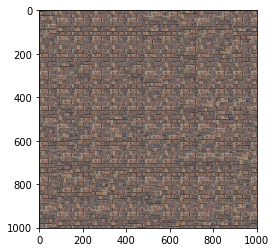

In [13]:
#patch_size = 51
overlap = 15
tol = 0.0001

(out_img_simple, out_img_simple_rgb) = quilt_simple(sample_img, out_size, patch_size, overlap, tol) #feel free to change parameters to get best results
out_img_simple_path = os.path.join(output_path, 'output_quilt_simple_'+ str(patch_size) + '.jpg')
if out_img_simple is not None:
    cv2.imwrite(out_img_simple_path, out_img_simple)
    plt.imshow(out_img_simple_rgb.astype('uint8'))

### Part III: Seam Finding (20 pts)


In [14]:
def custom_cut(err_patch):
    """
    Compute the minimum path frm the left to right side of the patch
    
    :param err_patch: numpy.ndarray    cost of cutting through each pixel
    :return: numpy.ndarray             a 0-1 mask that indicates which pixels should be on either side of the cut
    """
    
    #print('err_patch shape:', err_patch.shape)

    # create padding on top and bottom with very large cost
    padding = np.expand_dims(np.ones(err_patch.shape[1]).T*1e10,0)
    
    #print('padding shape:', padding.shape)
    
    err_patch = np.concatenate((padding, err_patch, padding), axis=0)

    h, w = err_patch.shape
    path = np.zeros([h,w], dtype="int")
    cost = np.zeros([h,w])
    cost[:,0] = err_patch[:, 0]
    cost[0,:] = err_patch[0, :]
    cost[cost.shape[0]-1,:] = err_patch[err_patch.shape[0]-1, :]
    
    # for each column, compute the cheapest connected path to the left
    # cost of path for each row from left upper/same/lower pixel
    for x in range(1,w):
        # cost of path for each row from left upper/same/lower pixel
        tmp = np.vstack((cost[0:h-2,x-1], cost[1:h-1, x-1], cost[2:h, x-1]))
        mi = tmp.argmin(axis=0)
        path[1:h-1, x] = np.arange(1, h-1, 1).T + mi # save the next step of the path
        cost[1:h-1, x] = cost[path[1:h-1, x] - 1, x-1] + err_patch[1:h-1, x]

    path = path[1:path.shape[0]-1, :] - 1
    cost = cost[1:cost.shape[0]-1, :]
    
    # create the mask based on the best path
    mask = np.zeros(path.shape, dtype="int")
    best_path = np.zeros(path.shape[1], dtype="int")
    best_path[len(best_path)-1] = np.argmin(cost[:, cost.shape[1]-1]) + 1
    mask[0:best_path[best_path.shape[0]-1], mask.shape[1]-1] = 1
    for x in range(best_path.size-1, 0, -1):
        best_path[x-1] = path[best_path[x]-1, x]
        mask[:best_path[x-1], x-1] = 1
    mask ^= 1
    return mask

In [15]:
def ssd_patch_seamcut(prev_patch, new_patch, patch_size, overlap, debug=False):
    
    height = patch_size
    width = 2*(patch_size - overlap)
    
    if(debug):
        print('ssd_patch:: template height: ', str(height) , ' width: ', width)
    
    template = np.zeros((height, width, 3))
    
    for i in range(height):
        k = 0
        for j in range(patch_size - overlap):
            template[i][j][0] = prev_patch[i][j][0]
            template[i][j][1] = prev_patch[i][j][1]
            template[i][j][2] = prev_patch[i][j][2]
            k += 1
        
        j = overlap
        while j < (patch_size-overlap):
            template[i][k+j][0] = new_patch[i][j][0]
            template[i][k+j][1] = new_patch[i][j][1]
            template[i][k+j][2] = new_patch[i][j][2]
            j += 1
            
        #print('After patch 1: current i: ', str(i),' current k: ', str(k))
            
    template_T = np.transpose(template)
    
   # Horizontal Cut
    mask_1 = np.zeros(template_T.shape)
    mask_1[0] = custom_cut(template_T[0])
    mask_1[1] = custom_cut(template_T[1])
    mask_1[2] = custom_cut(template_T[2])

    mask1 = np.transpose(mask_1)
    
    # Vertical Cut
    mask_2 = np.zeros(template_T.shape)
    mask_2[0] = np.transpose(custom_cut(np.transpose(template_T[0])))
    mask_2[1] = np.transpose(custom_cut(np.transpose(template_T[1])))
    mask_2[2] = np.transpose(custom_cut(np.transpose(template_T[2])))

    mask2 = np.transpose(mask_2)
    
    #print('\nMask1 shape: ', mask1.shape)
    #print('Mask2 shape: ', mask2.shape)
    
    mask = np.bitwise_and(mask1.astype('uint8'), mask2.astype('uint8'))
    
    #print('Mask shape: ', mask.shape)
    
    '''
     Reference: Assignment Tips
     Suppose I have a template T, a mask M, and an image I: then, 
     ssd = ((M*T)**2).sum() - 2 * cv2.filter2D(I, ddepth=-1, kernel = M*T) + cv2.filter2D(I ** 2, ddepth=-1, kernel=M)
    '''
    ssd = ((mask*template)**2).sum() - 2 * cv2.filter2D(new_patch, ddepth=-1, kernel=mask*template) \
            + cv2.filter2D(new_patch ** 2, ddepth=-1, kernel=mask)
    
    
    return ssd


In [16]:
def select_sample_seamcut(samples, prev_patch, patch_size, overlap, tol):
    
    total_samples = len(samples)
    if (prev_patch is None):
        i = random.randrange(0, total_samples)
        return samples[i]
    
    temp_height = patch_size
    temp_width = 2*(patch_size - overlap)
    
    center_i = int(temp_height/2)
    center_j = int(temp_width/2)
    
    patch_array = []
    ssd_array = []
    cost_array = []
    center_array = []

    sel_patch = None
    sel_patch_idx = -1
    min_cost = -1
    
    for i in range(total_samples):
        
        idx = random.randrange(0, total_samples)
        
        patch = samples[idx]
        ssd = ssd_patch_seamcut(prev_patch, patch, patch_size, overlap, False)
        min_cut  = np.zeros((3, temp_height))
        
        row = 0
        col = center_j
        
        # find min path for the cut
        while (row < temp_height):
            min_cut[0][row] = ssd[row][center_j][0]
            min_cut[1][row] = ssd[row][center_j][1]
            min_cut[2][row] = ssd[row][center_j][2]
            row += 1
            
        #print (min_cut)
        cost = np.sum(min_cut)
        
        patch_array.append(patch)
        ssd_array.append(ssd)
        cost_array.append(cost)
        
        if (min_cost == -1 or cost < min_cost):
            min_cost = cost
            sel_patch = patch
            sel_patch_idx = idx
            
    #print('Selected patch with index: ', str(sel_patch_idx), ' Cost: ', '{:.2f}'.format(min_cost))
    
    return sel_patch


In [17]:
def quilt_cut(in_img, out_size, patch_size, overlap, tol, target_img=None):
    """
    Samples square patches of size patchsize from sample using seam finding in order to create an output image of size outsize.
    Feel free to add function parameters
    :param sample: numpy.ndarray
    :param out_size: int
    :param patch_size: int
    :param overlap: int
    :param tol: float
    :return: numpy.ndarray
    """
        
    if (type(out_size).__name__ != 'int' or type(patch_size).__name__ != 'int' \
        or type(overlap).__name__ != 'int' or type(tol).__name__ != 'float'):
        print('Invalid datatype for at least one of the following:\n ', \
            '\t out_size: int\n', \
            '\t patch_size: int\n', \
            '\t overlap: int\n', \
            '\t tol: float\n')
    
        return None
    if (patch_size <= overlap):
        print('patch_size value (',str(patch_size),') should be greater than overlap (', str(overlap),')!')
        return None
    
    
    h,w,c = in_img.shape
    img_b, img_g, img_r = cv2.split(in_img)
    
    out_img_r = np.zeros((out_size, out_size))
    out_img_g = np.zeros((out_size, out_size))
    out_img_b = np.zeros((out_size, out_size))
                      
    dst_i = 0 
    dst_j = 0
    
    samples = generate_samples(in_img, patch_size)
    prev_patch = None
    
    num_patches = 0
    while dst_i < out_size: 
        
        template = [out_img_r, out_img_g, out_img_b]
        sample = select_sample_seamcut(samples, prev_patch, patch_size, overlap, tol) 
        num_patches += 1
        prev_patch = sample
        
        #print('quilt_simple:: sample.shape: ', sample.shape, ' sample: ', sample[:][:][0])
                
        while dst_j < out_size:
            '''
             TODO:
             
             For 'first' row, we only need to check to the 'left'
             
             But for the next row of patches, we need to check overlap with 2 sides:
                patch 'above' and patch to the 'left'
        
            '''
            for i in range(patch_size):
                if(dst_i + i == out_size):
                    break
                for j in range(patch_size):
                    if (dst_j + j == out_size):
                        break
                        
                    out_img_r[dst_i+i][dst_j+j] = sample[i][j][0]
                    out_img_g[dst_i+i][dst_j+j] = sample[i][j][1]
                    out_img_b[dst_i+i][dst_j+j] = sample[i][j][2]
                              
                #print('quilt_simple:: dst_i:', str(dst_i), ' i: ', str(i), \
                #  ' dst_j: ', str(dst_j),' j: ', str(j))
            
            dst_j += patch_size
            
            if (dst_j >= out_size):
                dst_j = 0
                break
            
            template = [out_img_r, out_img_g, out_img_b]
            sample = select_sample_seamcut(samples, prev_patch, patch_size, overlap, tol)   
            prev_patch = sample
            num_patches += 1
            
        dst_i += (patch_size)
            
        if (dst_i == out_size):
            break
       
    print('Number of patches utilized in generating image: ', str(num_patches))
    
    out_img_bgr = cv2.merge((out_img_b, out_img_g, out_img_r))
    out_img_rgb = cv2.merge((out_img_r, out_img_g, out_img_b))

    return (out_img_bgr, out_img_rgb)
    

In [18]:
(out_img_seamcut, out_img_seamcut_rgb) = quilt_cut(sample_img, out_size, patch_size, overlap, tol)
output_image_path_seam = os.path.join(output_path, 'output_quilt_seam_cut_'+ str(patch_size) + '.jpg')

if out_img_seamcut is not None:
    cv2.imwrite(output_image_path_seam, out_img_seamcut)

Number of samples generated: 11
Number of patches utilized in generating image:  169


Text(0.5, 1.0, 'Seam cut')

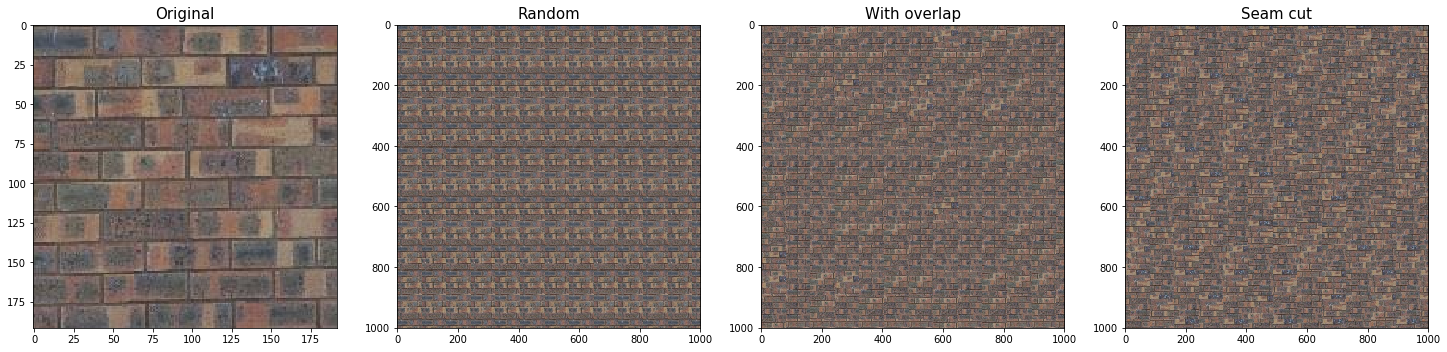

In [19]:
fig, axes = plt.subplots(1,4, figsize=(25,25))

axes[0].imshow(sample_img_rgb.astype('uint8'),cmap='gray') 
axes[0].set_title('Original', fontsize=15)

axes[1].imshow(out_img_rand_rgb.astype('uint8'),cmap='gray') 
axes[1].set_title('Random', fontsize=15)

axes[2].imshow(out_img_simple_rgb.astype('uint8'),cmap='gray') 
axes[2].set_title('With overlap', fontsize=15)

axes[3].imshow(out_img_seamcut_rgb.astype('uint8'),cmap='gray') 
axes[3].set_title('Seam cut', fontsize=15)




Image in use:  my_images/leather.png
Height:  374 Width:  375  channels:  3
in_img_b:  (374, 375)  in_img_g:  (374, 375)  in_img_r:  (374, 375)
Number of samples generated: 32
Number of samples generated: 32
Number of patches utilized in generating image:  400

Image in use:  my_images/table.jpg
Height:  485 Width:  485  channels:  3
in_img_b:  (485, 485)  in_img_g:  (485, 485)  in_img_r:  (485, 485)
Number of samples generated: 43
Number of samples generated: 43
Number of patches utilized in generating image:  400

Image in use:  my_images/cupboard.jpg
Height:  242 Width:  181  channels:  3
in_img_b:  (242, 181)  in_img_g:  (242, 181)  in_img_r:  (242, 181)
Number of samples generated: 13
Number of samples generated: 13
Number of patches utilized in generating image:  400

Image in use:  my_images/wallpaper.jpg
Height:  162 Width:  175  channels:  3
in_img_b:  (162, 175)  in_img_g:  (162, 175)  in_img_r:  (162, 175)
Number of samples generated: 11
Number of samples generated: 11
Numb

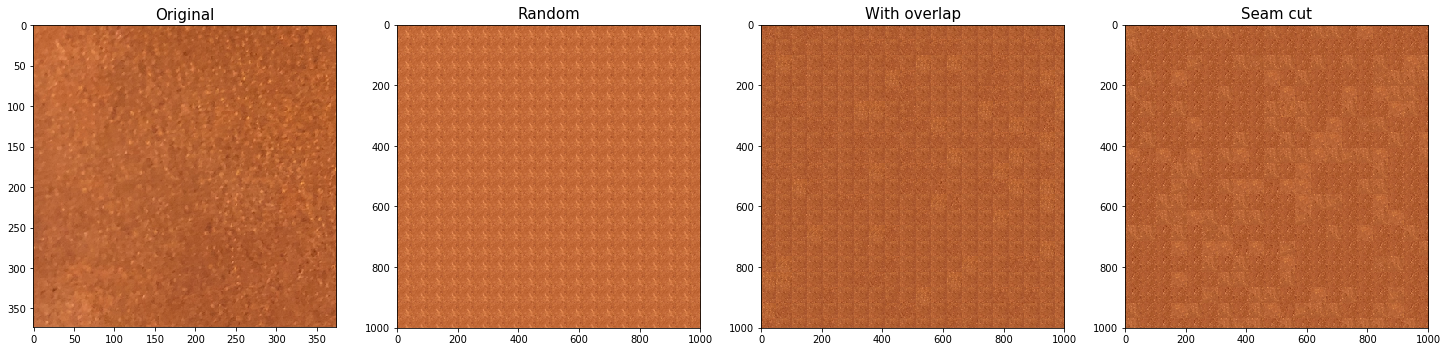

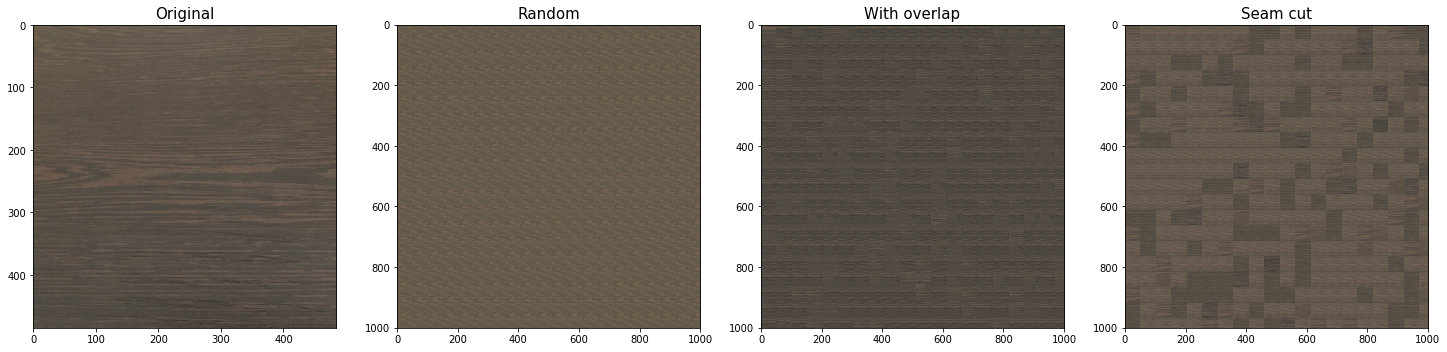

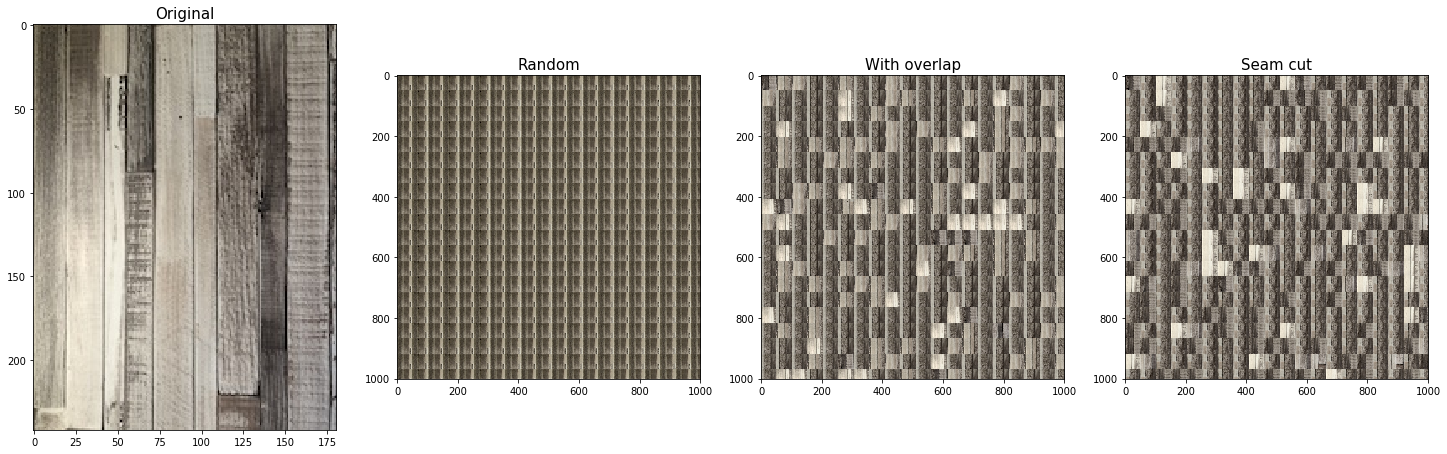

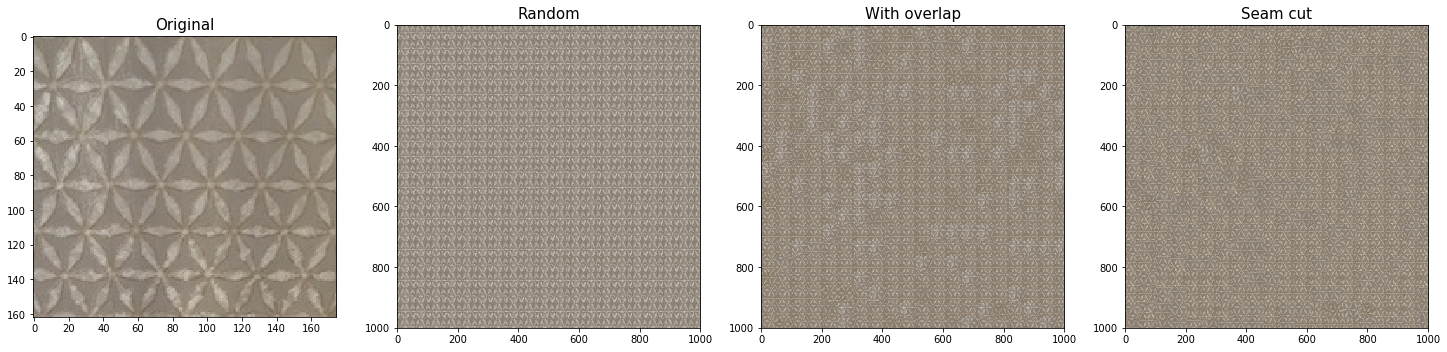

In [20]:
img1 = 'samples/texture.jpg'
img2 = 'samples/text_small.jpg'

img3 = 'my_images/leather.png'
img4 = 'my_images/table.jpg'
img5 = 'my_images/cupboard.jpg'
img6 = 'my_images/wallpaper.jpg'


output_size = 1001 
patch_size = 51
overlap = 5

for sample_img_path in (img3, img4, img5, img6):
    
    print('\nImage in use: ', sample_img_path)
    if not os.path.exists(sample_img_path):
        print('Image ', sample_img_path, ' does not exist')
        continue
        
    sample_img = cv2.imread(sample_img_path)
    sample_img_rgb = cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB)
    
    img_name = sample_img_path.split('/')[1]
    
    #print('Image shape: ', sample_img.shape)
    
    output_image_path_rand = os.path.join(output_path, 'output_rand_' + img_name)
    output_image_path_simple = os.path.join(output_path, 'output_simple_' + img_name)
    output_image_path_seamcut = os.path.join(output_path, 'output_seamcut_' + img_name )

    (out_img_rand, out_img_rand_rgb) = quilt_random(sample_img, out_size, patch_size)
    #print('Saving output image to ', output_image_path_rand)
    cv2.imwrite(output_image_path_rand, out_img_rand)
    
    (out_img_simple, out_img_simple_rgb) = quilt_simple(sample_img, out_size, patch_size, overlap, tol)
    #print('Saving output image to ', output_image_path_simple)
    cv2.imwrite(output_image_path_simple, out_img_simple)
    
    (out_img_seamcut, out_img_seamcut_rgb) = quilt_cut(sample_img, out_size, patch_size, overlap, tol)
    #print('Saving output image to ', output_image_path_seamcut)
    cv2.imwrite(output_image_path_seamcut, out_img_seamcut)
    
    fig, axes = plt.subplots(1,4, figsize=(25,25))

    axes[0].imshow(sample_img_rgb.astype('uint8'),cmap='gray') 
    axes[0].set_title('Original', fontsize=15)

    axes[1].imshow(out_img_rand_rgb.astype('uint8'),cmap='gray') 
    axes[1].set_title('Random', fontsize=15)

    axes[2].imshow(out_img_simple_rgb.astype('uint8'),cmap='gray') 
    axes[2].set_title('With overlap', fontsize=15)

    axes[3].imshow(out_img_seamcut_rgb.astype('uint8'),cmap='gray') 
    axes[3].set_title('Seam cut', fontsize=15)




### part IV: Texture Transfer (30 pts)

In [21]:
def texture_transfer(sample_img, target_img):
    """
    Feel free to add function parameters
    """
    print('sample shape: ', sample_img.shape)
    print('target shape: ', target_img.shape)
    
    h1, w1, c1 = sample_img.shape
    h2, w2, c2 = target_img.shape
        
    sample_img_grey = cv2.cvtColor(sample_img, cv2.COLOR_BGR2GRAY)
    target_img_grey = cv2.cvtColor(target_img, cv2.COLOR_BGR2GRAY)
    
    out_size = max (h2,w2)
    patch_size = int(min(h1, w1)/5)
    
    tol = 0.001
    
    print('out_size: ', str(out_size), ' patch_size: ', str(patch_size))
    
    target_img_grey_blurred = cv2.blur(target_img_grey, (5,5))
    
    texture_bgr, texture_rgb = quilt_cut(sample_img, out_size, patch_size, overlap, tol)
    texture_bgr_resized = texture_bgr[:h2,:w2,:c2]
    texture_bgr_resized_blurred = cv2.blur(texture_bgr_resized, (5,5))
    
    print('Generated texture shape: ', texture_bgr_resized.shape)
    
    output = np.zeros((h2, w2, 3))
    
    alpha = 0.8 
    v1 = (alpha) * texture_bgr_resized
    v2 = (1-alpha) * target_img_grey_blurred
    
    b,g,r = cv2.split(v1)
    b += v2
    g += v2
    r += v2
    
    output_bgr = cv2.merge((b,g,r))
    output_rgb = cv2.merge((r,g,b))
    
    
    return (output_bgr, output_rgb)



In [22]:
def texture_transfer_wrapper(target_img_path, sample_img_path):

    if (not os.path.exists(target_img_path)):
        print('Image does not exist', target_img_path)
        return
    
    if (not os.path.exists(sample_img_path)):
        print('Image does not exist', sample_img_path)
        return
        
    target_img = cv2.imread(target_img_path, 1)
    target_img_rgb = cv2.cvtColor(target_img, cv2.COLOR_BGR2RGB)
    
    sample_img = cv2.imread(sample_img_path, 1)
    img_name = sample_img_path.split('/')[1]

    sample_img_rgb = cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB)

    (out_img, out_img_rgb) = texture_transfer(sample_img, target_img)

    out_img_path = os.path.join(output_path, 'output_texture_transfer_' + img_name)
    cv2.imwrite(out_img_path, out_img)

    fig, axes = plt.subplots(1,3, figsize=(25,25))

    axes[0].imshow(sample_img_rgb.astype('uint8'),cmap='gray') 
    axes[0].set_title('Texture' , fontsize=15), axes[0].set_xticks([]), axes[0].set_yticks([])

    axes[1].imshow(target_img_rgb.astype('uint8'),cmap='gray') 
    axes[1].set_title('Target', fontsize=15), axes[1].set_xticks([]), axes[1].set_yticks([])  

    axes[2].imshow(out_img_rgb.astype('uint8'),cmap='gray') 
    axes[2].set_title('Texture Transfer', fontsize=15), axes[2].set_xticks([]), axes[2].set_yticks([])  


sample shape:  (374, 375, 3)
target shape:  (907, 1210, 3)
out_size:  1210  patch_size:  74
Number of samples generated: 30
Number of patches utilized in generating image:  289
Generated texture shape:  (907, 1210, 3)
sample shape:  (192, 192, 3)
target shape:  (907, 1210, 3)
out_size:  1210  patch_size:  38
Number of samples generated: 15
Number of patches utilized in generating image:  1024
Generated texture shape:  (907, 1210, 3)
sample shape:  (374, 375, 3)
target shape:  (355, 271, 3)
out_size:  355  patch_size:  74
Number of samples generated: 30
Number of patches utilized in generating image:  25
Generated texture shape:  (355, 271, 3)
sample shape:  (192, 192, 3)
target shape:  (355, 271, 3)
out_size:  355  patch_size:  38
Number of samples generated: 15
Number of patches utilized in generating image:  100
Generated texture shape:  (355, 271, 3)


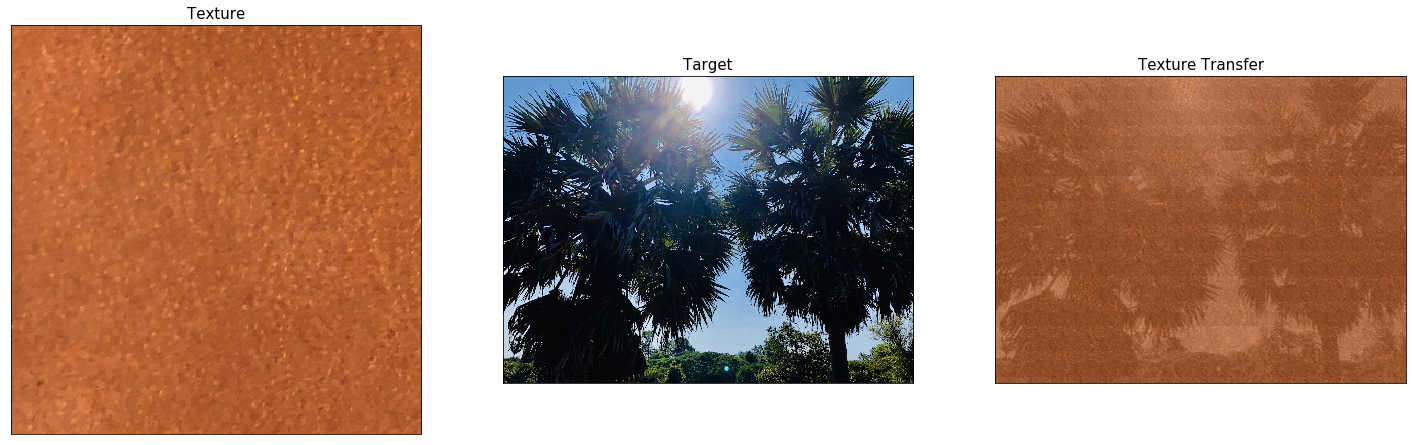

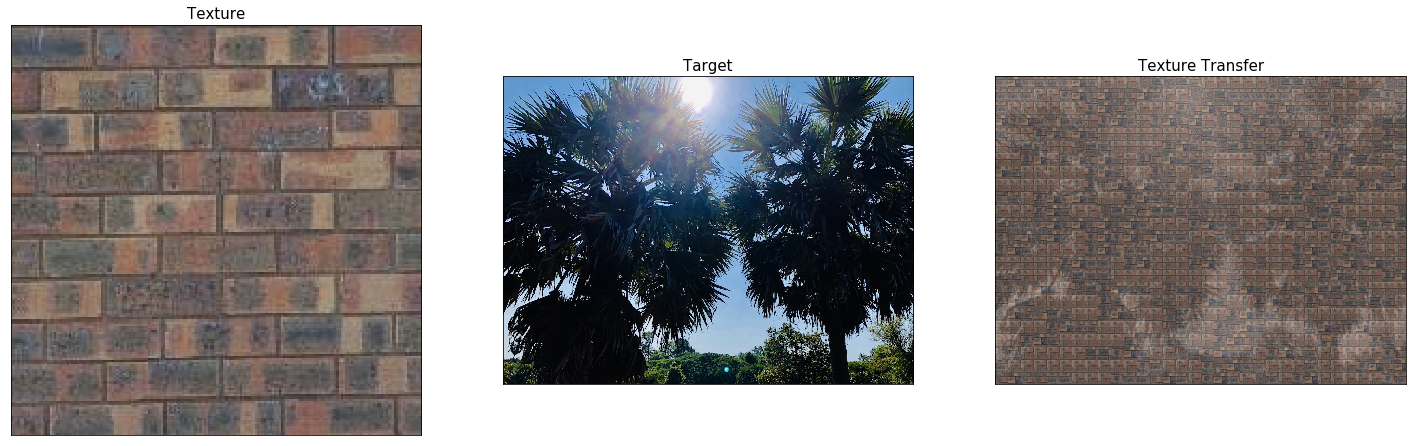

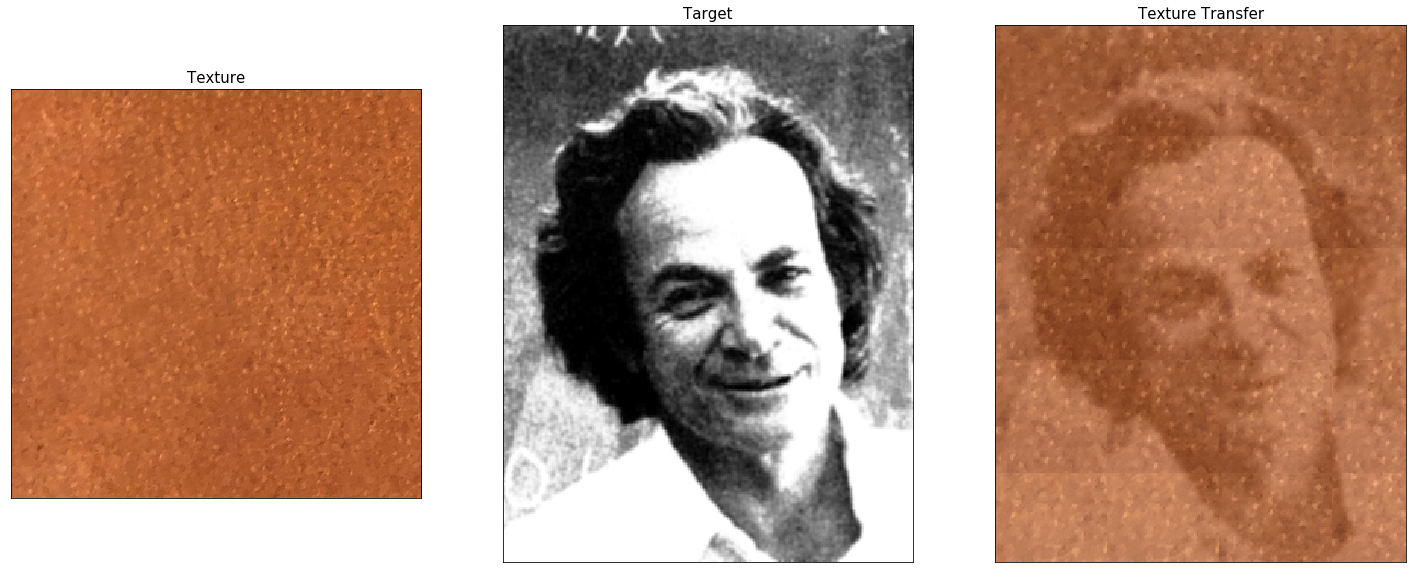

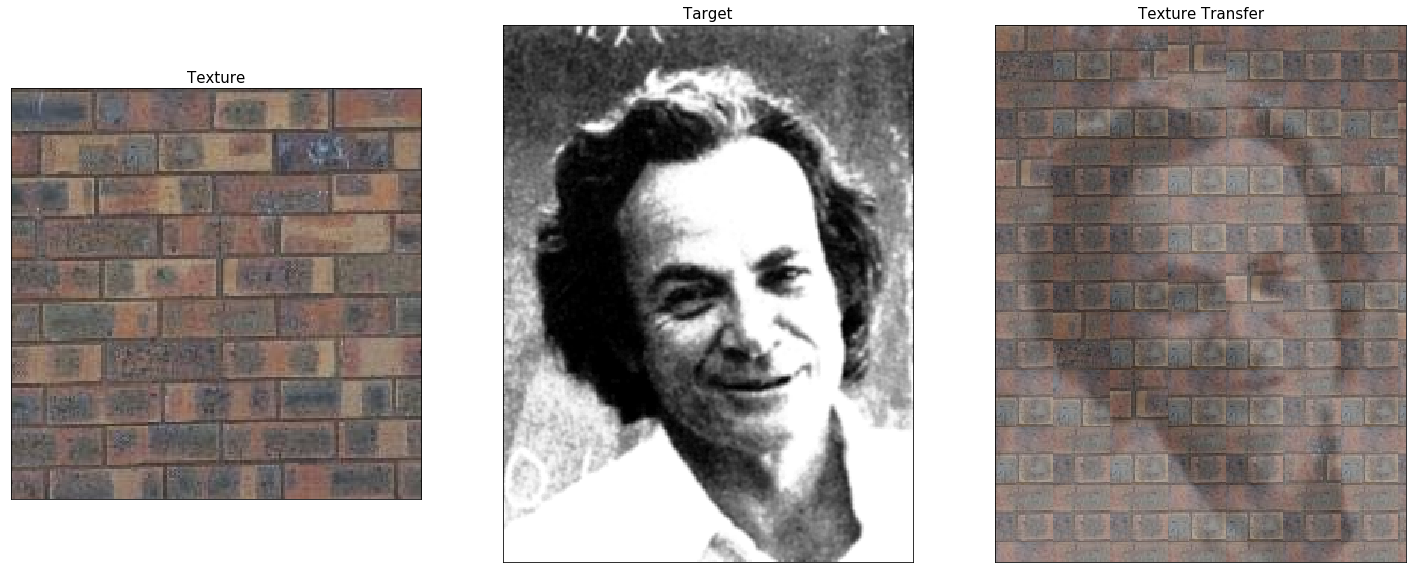

In [23]:
target_img1 = 'my_images/trees.jpg' 
target_img2 = 'samples/feynman.tiff'
sample_img1 = 'my_images/leather.png'
sample_img2 = 'samples/bricks_small.jpg'

texture_transfer_wrapper(target_img1, sample_img1)
texture_transfer_wrapper(target_img1, sample_img2)
texture_transfer_wrapper(target_img2, sample_img1)
texture_transfer_wrapper(target_img2, sample_img2)

### Bells & Whistles

(10 pts) Create and use your own version of cut.m. To get these points, you should create your own implementation without basing it directly on the provided function (you're on the honor code for this one). 

You can simply copy your customized_cut(bndcost) into the box below so that it is easier for us to grade

In [21]:
# optional or use cut(err_patch) directly
def customized_cut(bndcost):
    pass

(15 pts) Implement the iterative texture transfer method described in the paper. Compare to the non-iterative method for two examples.

(up to 20 pts) Use a combination of texture transfer and blending to create a face-in-toast image like the one on top. To get full points, you must use some type of blending, such as feathering or Laplacian pyramid blending.

(up to 40 pts) Extend your method to fill holes of arbitrary shape for image completion. In this case, patches are drawn from other parts of the target image. For the full 40 pts, you should implement a smart priority function (e.g., similar to Criminisi et al.).